# Finite differences for linear elasticity

## Definitions

In [1]:
from sympy import *

In [2]:
init_printing()

In [3]:
x, y, z = symbols("x y z")
x0, y0 = symbols("x0 y0")
h = symbols("h", positive=True)
u = symbols("u0:9")
v = symbols("v0:9")
lamda, mu = symbols("lamda mu")

In [4]:
def grad(u, coords=(x, y, z), h_vec=(1, 1, 1)):
    """
    Calcula el gradiente de una función escalar phi.
    
    Entrada
    =======
    u : SymPy expression
        Función escalar a la que se le desea calcular el gradiente.
    coords : Tupla (3), opcional
        Coordenadas del nuevo sistema de referencia. Esta variable es opcional
        y se toma un sistema cartesiano (x, y, z), por defecto.
    h_vec : Tupla (3), opcional
        Coeficientes de escala para el sistema coordenado. Se asume un sistema
        cartesiano por defecto (1, 1, 1).
        
    Devuelve
    ========
    gradiente: Matrix (3, 1)
        Vector columna con las componentes del gradiente.
    """
    return Matrix(3, 1, lambda i, j: u.diff(coords[i])/h_vec[j])

In [5]:
def grad_vec(A, coords=(x, y, z), h_vec=(1, 1, 1)):
    """
    Calcula el gradiente de una función vectorial A.
    
    Entrada
    =======
    A : Matrix (3, 1), lista
        Función vectorial a la que se le desea calcular el gradiente.
    coords : Tupla (3), opcional
        Coordenadas del nuevo sistema de referencia. Esta variable es opcional
        y se toma un sistema cartesiano (x, y, z), por defecto.
    h_vec : Tupla (3), opcional
        Coeficientes de escala para el sistema coordenado. Se asume un sistema
        cartesiano por defecto (1, 1, 1).
        
    Devuelve
    ========
    gradiente: Matrix (3, 3)
        Matriz con las componentes del gradiente. La posición (i, j) tiene como componentes
        diff(A[i], coords[j]), es coordenadas cartesianas, o su equivalente en el caso
        general.
    """ 
    return Matrix(3, 3, lambda i, j: (S(1)/h_vec[j])*A[i].diff(coords[j]))

In [6]:
def div(A, coords=(x, y, z), h_vec=(1, 1, 1)):
    """
    Calcula la divergencia de una función vectorial A.
    
    Entrada
    =======
    A : Matrix, lista
        Función escalar a la que se le desea calcular la divergencia.
    coords : Tupla (3), opcional
        Coordenadas del nuevo sistema de referencia. Esta variable es opcional
        y se toma un sistema cartesiano (x, y, z), por defecto.
    h_vec : Tupla (3), opcional
        Coeficientes de escala para el sistema coordenado. Se asume un sistema
        cartesiano por defecto (1, 1, 1).
        
    Devuelve
    ========
    divergencia: SymPy expression
        Divergencia de la función A
    """  
    h = h_vec[0]*h_vec[1]*h_vec[2]
    aux = simplify((S(1)/h)*sum(diff(A[k]*h/h_vec[k], coords[k])
                                for k in range(3)))
    return aux 

In [7]:
def rot(A, coords=(x, y, z), h_vec=(1, 1, 1)):
    """
    Calcula el rotacional de una función vectorial A.
    
    Entrada
    =======
    A : Matrix, Lista
        Función vectorial a la que se le desea calcular el rotacional.
    coords : Tupla (3), opcional
        Coordenadas del nuevo sistema de referencia. Esta variable es opcional
        y se toma un sistema cartesiano (x, y, z), por defecto.
    h_vec : Tupla (3), opcional
        Coeficientes de escala para el sistema coordenado. Se asume un sistema
        cartesiano por defecto (1, 1, 1).
        
    Devuelve
    ========
    rotacional : Matrix (3, 1)
        Vector columna con las componentes del rotacional.
    """  
    perm = lambda i, j, k: (i - j)*(j - k)*(k - i)/S(2)
    h = h_vec[0]*h_vec[1]*h_vec[2]
    aux = [(S(1)/h)*sum(perm(i, j, k)*h_vec[i]*diff(A[k]*h_vec[k], coords[j]) for j in range(3) for k in range(3))
           for i in range(3)]
    return Matrix(aux)  

In [8]:
def lap_vec(A, coords=(x, y, z), h_vec=(1, 1, 1)):
    """
    Calcula el laplaciano de una función vectorial A.
    
    Entrada
    =======
    A : Matrix, Lista
        Función vectorial a la que se le desea calcular el rotacional.
    coords : Tupla (3), opcional
        Coordenadas del nuevo sistema de referencia. Esta variable es opcional
        y se toma un sistema cartesiano (x, y, z), por defecto.
    h_vec : Tupla (3), opcional
        Coeficientes de escala para el sistema coordenado. Se asume un sistema
        cartesiano por defecto (1, 1, 1).
        
    Devuelve
    ========
    laplaciano : Matrix (3, 1)
        Vector columna con las componentes del laplaciano.
    """  
    return grad(div(A, coords=coords, h_vec=h_vec), coords=coords, h_vec=h_vec) -\
           rot(rot(A, coords=coords, h_vec=h_vec), coords=coords, h_vec=h_vec)

## Five-point stencil

Deduction of the five-point stencil approximation to the Laplacian using Lagrange interpolation.

In [9]:
pts = [[0, 0],
       [h, 0],
       [0, h],
       [-h, 0],
       [0, -h]]

In [10]:
terms = [S(1), x, y, x**2, y**2]

In [11]:
vander = Matrix(5, 5, lambda i, j: (terms[j]).subs({x: pts[i][0],
                                                   y: pts[i][1]}))

In [12]:
inv_vander = simplify(vander.inv())

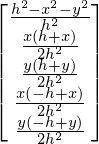

In [13]:
shape_funs = simplify(inv_vander.T * Matrix(terms))
shape_funs

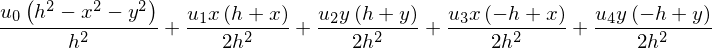

In [14]:
poly = sum(Matrix(u[:5]).T * shape_funs)
poly

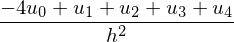

In [15]:
lap = diff(poly, x, 2) + diff(poly, y, 2)
simplify(lap)

In [16]:
U = poly
V = U.subs({u[k]: v[k] for k in range(5)})
disp = Matrix([U, V, 0])

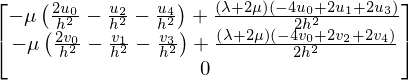

In [17]:
(lamda + 2*mu)*grad(div(disp)) - mu*rot(rot(disp))

In [18]:
strain = (grad_vec(disp) + grad_vec(disp).T).subs({x:0, y:0})

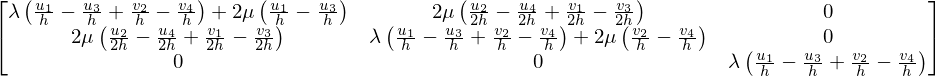

In [19]:
stress = lamda*strain.trace()*eye(3) + 2*mu*strain
stress

Tractions are given by

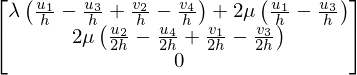

In [20]:
t1 = stress * Matrix([1, 0, 0])
t1

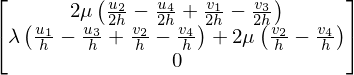

In [21]:
t2 = stress * Matrix([0, 1, 0])
t2

## Nine-point stencil

Deduction of the five-point stencil approximation to the Laplacian using Lagrange interpolation.

In [18]:
pts = [[0, 0],
       [h, 0],
       [0, h],
       [-h, 0],
       [0, -h],
       [h, h],
       [-h, h],
       [-h, -h],
       [h, -h]]

In [19]:
terms = [S(1), x, y, x**2, x*y, y**2, x**2*y, x*y**2, x**2*y**2]

In [20]:
vander = Matrix(9, 9, lambda i, j: (terms[j]).subs({x: pts[i][0],
                                                    y: pts[i][1]}))

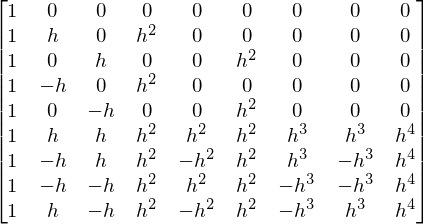

In [21]:
vander

In [22]:
inv_vander = simplify(vander.inv())

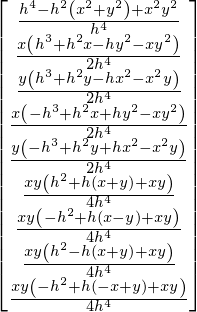

In [23]:
shape_funs = simplify(inv_vander.T * Matrix(terms))
shape_funs

In [24]:
poly = expand(sum(Matrix(u).T * shape_funs))

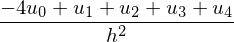

In [25]:
lap = diff(poly, x, 2) + diff(poly, y, 2)
simplify(lap.subs({x:0, y:0}))

In [26]:
U = poly
V = U.subs({u[k]: v[k] for k in range(9)})
disp = Matrix([U, V, 0])

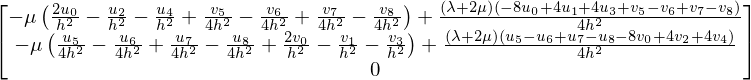

In [27]:
((lamda + 2*mu)*grad(div(disp)) - mu*rot(rot(disp))).subs({x:0, y:0})